In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import pickle
import sklearn
import time
from sklearn import metrics
from sklearn import model_selection

from scikeras.wrappers import KerasClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [103]:
%run SharedFunctions.ipynb

Učitava se prethodno pripremljen skup podataka: 

In [3]:
data = pd.read_csv('data/data_longer.csv')
data.drop(columns=['Unnamed: 0'], inplace=True)

In [4]:
data.shape

(223453, 9)

### 1. Podela na trening, test, i validacioni skup

In [5]:
# data.head()

In [6]:
X = data['comment_text']
y = data['target']

In [7]:
X_train_validation, X_test, y_train_validation, y_test = \
    model_selection.train_test_split(X, y, test_size=0.33, stratify=y, random_state=7)

X_train, X_validation, y_train, y_validation =\
    model_selection.train_test_split(X_train_validation, y_train_validation, test_size=0.2, stratify=y_train_validation, random_state=7)

In [8]:
X_train.shape, X_validation.shape, X_test.shape

((119770,), (29943,), (73740,))

In [9]:
y_train.shape, y_validation.shape, y_test.shape

((119770,), (29943,), (73740,))

### 2. Tokenizacija I vektorizacija teksta

In [10]:
# uzima se recimo 20000 najfrekventinijh reci
max_features = 20000

# max duzina
max_len = 100

In [11]:
word_index, tokenizer = get_vocabulary(max_features, X_train, 'tokenizer_binary.pickle')

In [12]:
print('Broj jedinstvenih reci:', len(word_index))

Broj jedinstvenih reci: 201164


Sada pravimo skupove za trening, test i validaciju sa vektorizovanim tekstom

In [13]:
X_train = to_sequence(X_train, max_len, tokenizer)
X_test = to_sequence(X_test, max_len, tokenizer)
X_validation = to_sequence(X_validation, max_len, tokenizer)

In [14]:
X_train.shape, X_test.shape, X_validation.shape

((119770, 100), (73740, 100), (29943, 100))

In [15]:
X_train_validation = to_sequence(X_train_validation, max_len, tokenizer)

Kreira se matrica ugnjezdavanja

In [16]:
embedding_matrix = create_embedding_matrix(word_index, max_len)

### 3. Selekcija i evaluacija modela

In [29]:
# Posto su klasa nebalansirane, potrebno je dodeliti im tezine
# tako da se vise kaznjava pogresna klasifikacija manjinske klase

weights = get_weights(y_train_validation)
# TODO da li ovde treba train and validation

# tezinu za klasu 1 podesavamo rucno jer se ispostavlja da
# bolje klasifikuje TP instance ako nije bas tacna proporcija
# weights[1] = 3.5
weights

{0: 0.5558967465969598, 1: 4.97253221735087}

Za podešavanje hiperparametara koristiće se randomizovana unakrsna validacija i keras wrapper 

In [32]:
# recnik parametara koje prima funkcija za kreiranje modela
params = {'num_of_classes' : [2],
          'num_of_features' : [20000],
          'embedding_dim' : [100],
          'kernel_size' : [3, 5, 7],
          'pool_size' : [3, 5],
          'filters' : [32, 64, 128],
          'dropout_rate' : [0.2, 0.4],
          'maxlen' : [100],
          'lr' : [0.00001, 0.0001, 0.001],
          'embedding_matrix' : [embedding_matrix],
          'layers' : [0, 1, 2]
          }
    

model_random = KerasClassifier(build_fn = create_model, epochs=10, batch_size=128, verbose=True)

randomized_cv = RandomizedSearchCV(estimator=model_random, param_distributions=params, cv=2, verbose=1, n_iter=2)

C:\Users\Petrovic\AppData\Local\Temp\ipykernel_4964\1534207424.py:15: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_random = KerasClassifier(build_fn = create_model, epochs=10, batch_size=128, verbose=True)


In [33]:
randomized_cv.fit(X_train_validation, y_train_validation, class_weight=weights)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 100)           2000000   
                                                                 
 conv1d_10 (Conv1D)          (None, 50, 64)            32064     
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 16, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_11 (Conv1D)          (None, 16, 64)            20544     
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 5, 64)            0         
 g1D)                                                            
                                                             

Total params: 2,146,305
Trainable params: 146,305
Non-trainable params: 2,000,000
_________________________________________________________________
Epoch 1/10
585/585 [==============================] - 29s 48ms/step - loss: 0.6489 - accuracy: 0.7315
Epoch 2/10
585/585 [==============================] - 27s 47ms/step - loss: 0.5703 - accuracy: 0.6739
Epoch 3/10
585/585 [==============================] - 27s 46ms/step - loss: 0.5239 - accuracy: 0.6775
Epoch 4/10
585/585 [==============================] - 27s 45ms/step - loss: 0.4968 - accuracy: 0.6991
Epoch 5/10
585/585 [==============================] - 27s 46ms/step - loss: 0.4769 - accuracy: 0.7236
Epoch 6/10
585/585 [==============================] - 27s 46ms/step - loss: 0.4609 - accuracy: 0.7469
Epoch 7/10
585/585 [==============================] - 27s 46ms/step - loss: 0.4489 - accuracy: 0.7659
Epoch 8/10
585/585 [==============================] - 27s 45ms/step - loss: 0.4383 - accuracy: 0.7856
Epoch 9/10
585/585 [================

C:\Users\Petrovic\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
2 fits failed out of a total of 4.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Petrovic\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Petrovic\anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py", line 236, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "C:\Users\Petrovic\anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py", line 164, in fit
    history = self.model.fit(x, y, **fi

1170/1170 [==============================] - 54s 45ms/step - loss: 0.6063 - accuracy: 0.6957
Epoch 2/10
1170/1170 [==============================] - 53s 45ms/step - loss: 0.5085 - accuracy: 0.6863
Epoch 3/10
1170/1170 [==============================] - 55s 47ms/step - loss: 0.4642 - accuracy: 0.7465
Epoch 4/10
1170/1170 [==============================] - 55s 47ms/step - loss: 0.4368 - accuracy: 0.7894
Epoch 5/10
1170/1170 [==============================] - 55s 47ms/step - loss: 0.4203 - accuracy: 0.8105
Epoch 6/10
1170/1170 [==============================] - 56s 48ms/step - loss: 0.4082 - accuracy: 0.8214
Epoch 7/10
1170/1170 [==============================] - 54s 46ms/step - loss: 0.3979 - accuracy: 0.8299
Epoch 8/10
1170/1170 [==============================] - 54s 46ms/step - loss: 0.3890 - accuracy: 0.8380
Epoch 9/10
1170/1170 [==============================] - 56s 47ms/step - loss: 0.3810 - accuracy: 0.8435
Epoch 10/10
1170/1170 [==============================] - 57s 49ms/step - lo

RandomizedSearchCV(cv=2,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x00000174CB172A30>,
                   n_iter=2,
                   param_distributions={'dropout_rate': [0.2, 0.4],
                                        'embedding_dim': [100],
                                        'embedding_matrix': [array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [-0.18970001,  0.050024  ,  0.19084001, ..., -0.39804   ,
         0...
       [ 0.29811999,  0.053545  ,  0.27474001, ..., -0.51871002,
        -0.73246002,  0.54639   ],
       [ 0.48453999, -0.66696   ,  0.31995001, ..., -0.2985    ,
        -0.36061999,  0.23197   ],
       [ 0.25542   ,  0.34395   , -0.28141999, ...,  0.20162   ,
        -0.4488    ,  0.023272  ]])],
                                        'filters': [32, 64, 128],


In [35]:
randomized_cv.best_params_

{'pool_size': 3,
 'num_of_features': 20000,
 'num_of_classes': 2,
 'maxlen': 100,
 'lr': 1e-05,
 'kernel_size': 5,
 'filters': 128,
 'embedding_matrix': array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
          0.82779998,  0.27061999],
        [-0.18970001,  0.050024  ,  0.19084001, ..., -0.39804   ,
          0.47646999, -0.15983   ],
        ...,
        [ 0.29811999,  0.053545  ,  0.27474001, ..., -0.51871002,
         -0.73246002,  0.54639   ],
        [ 0.48453999, -0.66696   ,  0.31995001, ..., -0.2985    ,
         -0.36061999,  0.23197   ],
        [ 0.25542   ,  0.34395   , -0.28141999, ...,  0.20162   ,
         -0.4488    ,  0.023272  ]]),
 'embedding_dim': 100,
 'dropout_rate': 0.2}

### 4. Formiranje modela

In [93]:
kernel_size = 3
pool_size = 4
filters = 64
dropout_rate = 0.3
embedding_dim = 100
lr = 0.0001
layers = 1

In [94]:
binary_model = create_model(num_of_classes = 2, num_of_features = max_features, embedding_dim = embedding_dim, 
                kernel_size = kernel_size, pool_size = pool_size, filters = filters, 
                dropout_rate = dropout_rate, maxlen = max_len, lr = lr, embedding_matrix = embedding_matrix, layers=layers)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 100, 100)          2000000   
                                                                 
 conv1d_28 (Conv1D)          (None, 100, 64)           19264     
                                                                 
 max_pooling1d_28 (MaxPoolin  (None, 25, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_29 (Conv1D)          (None, 25, 128)           24704     
                                                                 
 max_pooling1d_29 (MaxPoolin  (None, 6, 128)           0         
 g1D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 6, 128)          

### 5. Obučavanje modela

In [112]:
weights[1] = 3.5

In [115]:
epochs = 13
batch_size = 64

In [116]:
start = time.time()    

binary_history = binary_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                                 validation_data=(X_validation, y_validation), class_weight=weights)
                                 #,callbacks=[early_stop]
                                 
print('Trajanje obucavanja modela binarne klasifikacije: ', time.time() - start)

Epoch 1/13
1872/1872 [==============================] - 28s 15ms/step - loss: 0.2112 - accuracy: 0.9202 - f1_m: 0.6688 - val_loss: 0.1983 - val_accuracy: 0.9278 - val_f1_m: 0.6782
Epoch 2/13
1872/1872 [==============================] - 28s 15ms/step - loss: 0.2033 - accuracy: 0.9223 - f1_m: 0.6798 - val_loss: 0.2040 - val_accuracy: 0.9260 - val_f1_m: 0.6761
Epoch 3/13
1872/1872 [==============================] - 29s 15ms/step - loss: 0.1974 - accuracy: 0.9243 - f1_m: 0.6866 - val_loss: 0.2252 - val_accuracy: 0.9158 - val_f1_m: 0.6567
Epoch 4/13
1872/1872 [==============================] - 30s 16ms/step - loss: 0.1915 - accuracy: 0.9258 - f1_m: 0.6907 - val_loss: 0.2372 - val_accuracy: 0.9087 - val_f1_m: 0.6410
Epoch 5/13
1872/1872 [==============================] - 28s 15ms/step - loss: 0.1863 - accuracy: 0.9272 - f1_m: 0.6947 - val_loss: 0.2416 - val_accuracy: 0.9078 - val_f1_m: 0.6402
Epoch 6/13
1872/1872 [==============================] - 29s 16ms/step - loss: 0.1804 - accuracy: 0.9

Prate se tacnost, funkcija gubitka i F1 mera (jer klase nisu izbalansirane)

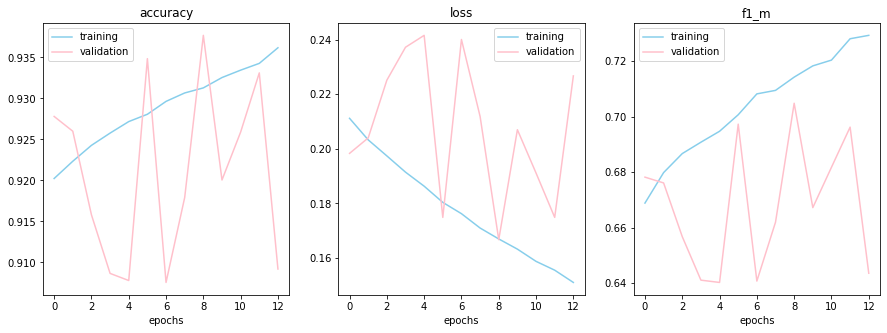

In [117]:
# Grafici koji prikazuju promene metrika na trening skupu i validacionom skupu kroz epohe tokom treniranja

plot_graphs(binary_history, ['accuracy', 'loss', 'f1_m'])

### 6. Evaluacija modela

In [118]:
scores = binary_model.evaluate(X_test, y_test)
print('Loss: ', scores[0])
print('Test accuracy: ', scores[1])

2305/2305 [==============================] - 6s 3ms/step - loss: 0.2270 - accuracy: 0.9086 - f1_m: 0.6258
Loss:  0.22704654932022095
Test accuracy:  0.9086248874664307


Predviđanje: 

In [119]:
y_predicted = binary_model.predict(X_test)

2305/2305 [==============================] - 6s 3ms/step


In [120]:
# sigmoidna funkcija:

y_labels = [int(score > 0.5) for score in y_predicted]

In [121]:
# F1 mera je bolja metrika kada su neizbalansirane klase

print('F1: ', metrics.f1_score(y_test, y_labels))

F1:  0.6591460946985026


In [122]:
cf = metrics.confusion_matrix(y_test, y_labels)
print(cf)

[[60487  5839]
 [  899  6515]]


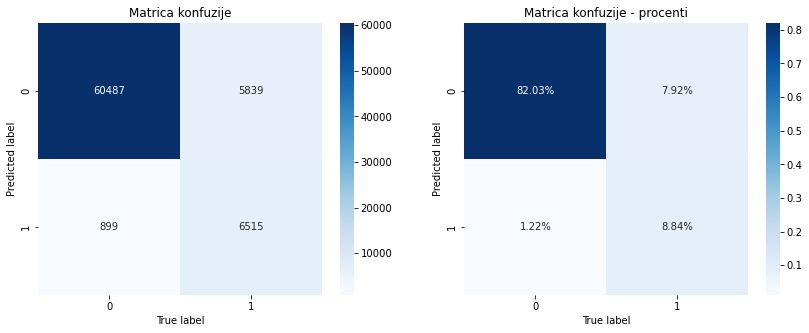

In [123]:
# funkcija koja prikazuje matricu konfuzije i 
# istu tu matricu sa vrednostima u  procentima

plot_cf(cf, 'binary')

In [124]:
print('---------------------- IZVESTAJ -----------------------\n')
print(metrics.classification_report(y_test, y_labels))

---------------------- IZVESTAJ -----------------------

              precision    recall  f1-score   support

           0       0.99      0.91      0.95     66326
           1       0.53      0.88      0.66      7414

    accuracy                           0.91     73740
   macro avg       0.76      0.90      0.80     73740
weighted avg       0.94      0.91      0.92     73740

